# RETRIEVAL ENSEMBLE

Dataset: https://huggingface.co/datasets/merve/turkish_instructions

## PREPROCESSING

In [5]:
import pandas as pd 
df = pd.read_csv("soru_cevap.csv")
df.head()

,soru,insan cevabı,makine cevabı,tercih
0,Boğaz köprüsünün sudan yüksekliği kaç metredir?,Boğaz köprüsü denizden 64 metre yüksekliğe sah...,64 metre,3
1,Türkiye'de en yüksek puanla öğrenci kabul eden...,Türkiye'de en yüksek puanla öğrenci kabul eden...,Orta Doğu Teknik Üniversitesi (ODTÜ),1
2,YYTÜ kaç kampüse sahiptir?,Yıldız Teknik Üniversitesi'nin iki adet kampüs...,"Yıldız Teknik Üniversitesi (YTÜ), İstanbul'da ...",2
3,Paris'in en ünlü yapısı nedir?,Paris denince akıllara ilk olarak Eyfel Kulesi...,Eyfel Kulesi,3
4,Uzaya insanlı ilk uçuş ne zaman yapıldı?,Uzaya insanlı ilk uçş 1961 yılında yapılmştır.,12 Nisan 1961,3


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16730 entries, 0 to 16729
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   soru           16730 non-null  object
 1   insan cevabı   16730 non-null  object
 2   makine cevabı  16730 non-null  object
 3   tercih         16730 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 522.9+ KB


In [7]:
df.columns

Index(['soru', 'insan cevabı', 'makine cevabı', 'tercih'], dtype='object')

In [8]:
sampled_df = df.sample(n=2000, random_state=42)

In [9]:
new_df = pd.DataFrame()
new_df['instruction'] = sampled_df['soru']


In [10]:
new_df['output'] = sampled_df.apply(
    lambda row: row['insan cevabı'] if row['tercih'] in [1, 3] else row['makine cevabı'],
    axis=1
)
df = new_df

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 12773 to 10272
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   instruction  2000 non-null   object
 1   output       2000 non-null   object
dtypes: object(2)
memory usage: 46.9+ KB


In [12]:
df['instruction'] = df['instruction'].str.strip()
df['output'] = df['output'].str.strip()
df

,instruction,output
12773,Ders çalışma motivasyonu nasıl sağlanır?,"Ders çalışma motivasyonunu arttırmak için, önc..."
9152,Resim çizerken kağıt yerine neler kullanılabilir?,Resim çizerken kağıt yerine boya tutan farklı ...
6698,İnsanlar liseye kadar okumalı mıdır?,İnsanların eğitim düzeyi diğer insanlarıda etk...
16538,Alçak basınç noktalarından yüksek basınç nokta...,Rüzgarlar yüksek basınç noktalarından alçak ba...
3280,"Dil, bir ulusun en önemli unsuru mudur?",Dil bir ulusun en önemli unsurlarından biridir...
...,...,...
2141,Netflix olmasaydı kitap okumak için hangi tabl...,"Netflix bir tablet değil, kitap okumakla alaka..."
13511,Dünyanın çekirdeği donsaydı ne olurdu?,"Dünyanın çekirdeği donarsa, gezegenimizin many..."
1022,Büyük Fast Food şirketleri hangileridir,"Bu şirketelere McDonald's, Kentucky Fried Chi..."
2742,"Yapay zeka her alanda insan zekasını aşsaydı, ...","Yapay zeka her alanda insan zekasını aşarsa, b..."


## EMBEDDING

In [13]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import os
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

In [14]:
output_dir = "embeddings_2"
os.makedirs(output_dir, exist_ok=True)

In [15]:
models = {
    "cosmos-colbert" : "ytu-ce-cosmos/turkish-colbert",
    "minilm": "sentence-transformers/all-MiniLM-L12-v2",
    "bge": "BAAI/bge-m3",
    "jina" : "jinaai/jina-embeddings-v3",
    "gte" : "thenlper/gte-large"
}

In [16]:
#!pip install requests==2.27.1

In [17]:
# Generates and saves embeddings for a list of texts using a specified pretrained model.
# It tokenizes the texts, passes them through the model to extract embeddings, and saves the embeddings as a .npy file.
def get_embeddings(texts, model_name, save_path):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
            embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        embeddings.append(embedding)

    embeddings = np.array(embeddings)
    np.save(save_path, embeddings) # Save the embeddings to the specified path as a .npy file

In [18]:
for model_name, model_path in models.items():
    print(f"Processing model: {model_name}")
    
    instruction_save_path = os.path.join(output_dir, f"{model_name}_instruction_embeddings.npy")
    get_embeddings(df["instruction"], model_path, instruction_save_path)
    
    output_save_path = os.path.join(output_dir, f"{model_name}_output_embeddings.npy")
    get_embeddings(df["output"], model_path, output_save_path)

print("Saved embedding files.")

Processing model: cosmos-colbert
Processing model: minilm
Processing model: bge
Processing model: jina
Processing model: gte
Saved embedding files.


## RETRIEVAL TOP1 VE TOP5 RESULT

In [19]:
# Finds top-k similar embeddings for each input embedding.
# Uses cosine similarity to measure similarity.
# Returns indices and similarity scores of top-k matches.

def find_top_matches(instruction_embeddings, output_embeddings, top_k=5): 
    results = []
    similarities_list = []
    for instruction in instruction_embeddings:
        similarities = cosine_similarity([instruction], output_embeddings)[0]
        top_indices = similarities.argsort()[-top_k:][::-1]
        results.append(top_indices)
        similarities_list.append(similarities[top_indices])
    return results, similarities_list

In [20]:
# Calculates Top-1 and Top-5 success rates for a matching task.
# Compares original outputs with retrieved outputs from top_matches.
# Returns success rates as percentages for Top-1 and Top-5 matches.

def calculate_success_rate(df, top_matches):
    top1_success = 0
    top5_success = 0

    for i, indices in enumerate(top_matches):
        original_output = df.iloc[i]['output']
        retrieved_outputs = [df.iloc[idx]['output'] for idx in indices]
        if original_output == retrieved_outputs[0]:
            top1_success += 1
        if original_output in retrieved_outputs:
            top5_success += 1

    top1_rate = top1_success / len(df) * 100
    top5_rate = top5_success / len(df) * 100

    return top1_rate, top5_rate

In [21]:
results = {}
for model_name in models:
    print(f"MODEL: {model_name.upper()}")
    
    instruction_embeddings = np.load(os.path.join(output_dir, f"{model_name}_instruction_embeddings.npy"))
    output_embeddings = np.load(os.path.join(output_dir, f"{model_name}_output_embeddings.npy"))

    top_matches, similarities_list = find_top_matches(instruction_embeddings, output_embeddings)

    for i, (indices, similarities) in enumerate(zip(top_matches, similarities_list)):
        if i >= 10: 
            break
        original_output = df.iloc[i]['output']
        top1_output = df.iloc[indices[0]]['output']
        top5_outputs = [df.iloc[idx]['output'] for idx in indices]

        print(f"\n=== Question {i+1} ===")
        print(f"Instruction: {df.iloc[i]['instruction']}")
        print(f"Original Answer: {original_output}\n")
        print(f"Top 1 Answer: {top1_output} (Similarity: {similarities[0]:.4f})\n")
        print("Top 5 Answers:")
        for rank, (answer, similarity) in enumerate(zip(top5_outputs, similarities), 1):
            print(f"  {rank}. {answer} (Similarity: {similarity:.4f})")

    top1_rate, top5_rate = calculate_success_rate(df, top_matches)
    results[model_name] = {"top1": top1_rate, "top5": top5_rate}

MODEL: COSMOS-COLBERT

=== Question 1 ===
Instruction: Ders çalışma motivasyonu nasıl sağlanır?
Original Answer: Ders çalışma motivasyonunu arttırmak için, öncelikle ulaşılabilir ve ölçülebilir hedefler belirlemek önemlidir. Bu hedefleri belirlerken, çalışma zamanınızı planlayarak ve düzenli bir çalışma rutini oluşturarak başlayabilirsiniz. Ders çalışma sürecinde düzenli aralıklarla kısa molalar vermek, motivasyonunuzu korumanıza yardımcı olabilir. Ayrıca, ilginizi çeken konuları seçmek ve başarılarınızı kutlamak da motivasyonu artırabilir.

Top 1 Answer: Ders çalışma motivasyonunu arttırmak için, öncelikle ulaşılabilir ve ölçülebilir hedefler belirlemek önemlidir. Bu hedefleri belirlerken, çalışma zamanınızı planlayarak ve düzenli bir çalışma rutini oluşturarak başlayabilirsiniz. Ders çalışma sürecinde düzenli aralıklarla kısa molalar vermek, motivasyonunuzu korumanıza yardımcı olabilir. Ayrıca, ilginizi çeken konuları seçmek ve başarılarınızı kutlamak da motivasyonu artırabilir. (Sim

In [22]:
model_names = list(results.keys())
top1_scores = [results[model]['top1'] for model in model_names]
top5_scores = [results[model]['top5'] for model in model_names]

<Figure size 1200x700 with 0 Axes>

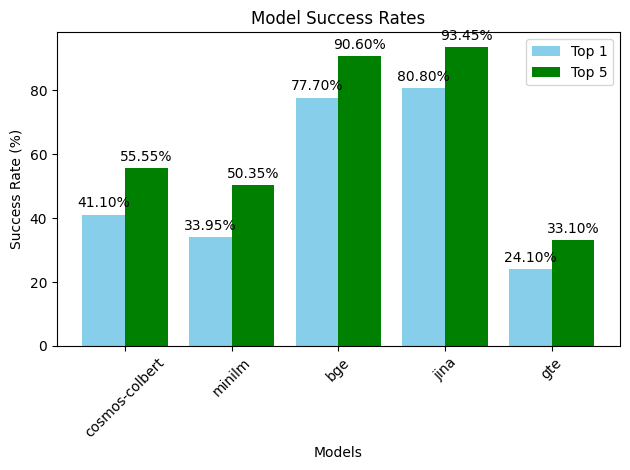

In [23]:
x = np.arange(len(model_names))
width = 0.4  

plt.figure(figsize=(12, 7))
fig, ax = plt.subplots()
bar1 = ax.bar(x - width/2, top1_scores, width, label='Top 1', color='skyblue')
bar2 = ax.bar(x + width/2, top5_scores, width, label='Top 5', color='green')

for bar in bar1:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

for bar in bar2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

ax.set_xlabel("Models")
ax.set_ylabel("Success Rate (%)")
ax.set_title("Model Success Rates")
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()


## ENSEMBLE-1: MAJORITY VOTING

- For Top1: Each model's Top1 result is considered a vote. The sentence that receives the most votes is selected as the ensemble Top1. In case of a tie, the sentence with the highest similarity score is chosen.
- For Top5: The Top5 results from all models are combined, and the sentences with the highest frequency (most votes) are selected as the ensemble Top5. In case of ties, similarity scores are used for tie-breaking.

In [24]:
# Evaluates the performance of an ensemble model.
# Compares the ensemble's Top-1 and Top-5 predictions with the original outputs.
# Returns success rates as percentages for Top-1 and Top-5 matches.

def evaluate_ensemble(df, ensemble_top1, ensemble_top5):
    top1_success = sum(df.iloc[i]['output'] == ensemble_top1[i] for i in range(len(df)))
    top5_success = sum(df.iloc[i]['output'] in ensemble_top5[i] for i in range(len(df)))
    
    top1_rate = (top1_success / len(df)) * 100
    top5_rate = (top5_success / len(df)) * 100
    return top1_rate, top5_rate

In [25]:
def voting_ensemble(models, df, output_dir, top_k=5):
    top1_votes = []
    top5_votes = []
    similarities_list_combined = []

    for model_name in models: # Collect top1 and top5 for all models
        instruction_embeddings = np.load(os.path.join(output_dir, f"{model_name}_instruction_embeddings.npy"))
        output_embeddings = np.load(os.path.join(output_dir, f"{model_name}_output_embeddings.npy"))
        top_matches, similarities_list = find_top_matches(instruction_embeddings, output_embeddings, top_k)
        top1_votes.append([df.iloc[indices[0]]['output'] for indices in top_matches])
        top5_votes.append([[df.iloc[idx]['output'] for idx in indices] for indices in top_matches])
        similarities_list_combined.append(similarities_list)

    ensemble_top1 = []     # Determine ensemble Top1
    for i in range(len(df)):
        top1_candidates = [votes[i] for votes in top1_votes]
        vote_counts = Counter(top1_candidates)
        most_common = vote_counts.most_common()
        if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
            similarities = {candidate: max(similarities_list_combined[m][i][0] for m, votes in enumerate(top1_votes) if votes[i] == candidate) for candidate, _ in most_common}
            selected = max(similarities, key=similarities.get)
        else:
            selected = most_common[0][0]
        ensemble_top1.append(selected)

    ensemble_top5 = []     # Determine ensemble Top5
    for i in range(len(df)):
        all_candidates = [output for top5 in top5_votes for output in top5[i]]
        vote_counts = Counter(all_candidates)
        top5_candidates = [output for output, _ in vote_counts.most_common(top_k)]
        ensemble_top5.append(top5_candidates)

    return ensemble_top1, ensemble_top5

In [26]:
ensemble_top1, ensemble_top5 = voting_ensemble(models, df, output_dir)

In [27]:
ensemble_top1_rate, ensemble_top5_rate = evaluate_ensemble(df, ensemble_top1, ensemble_top5)


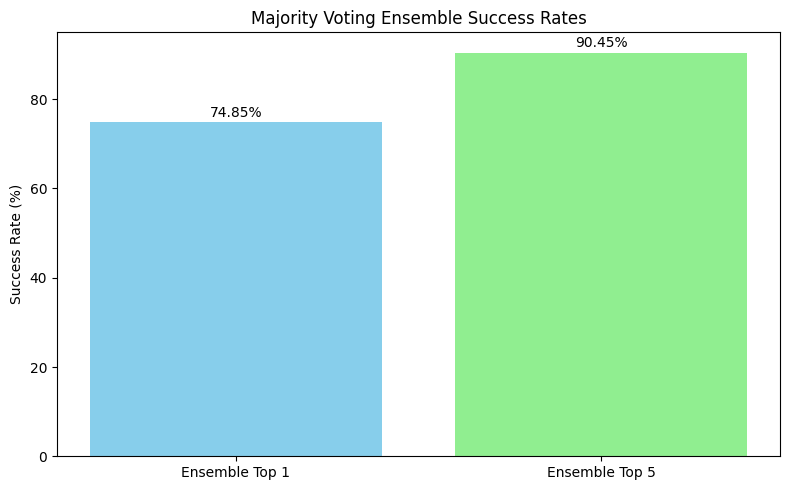

In [28]:
plt.figure(figsize=(8, 5))
plt.bar(["Ensemble Top 1", "Ensemble Top 5"], [ensemble_top1_rate, ensemble_top5_rate], color=['skyblue', 'lightgreen'])
plt.ylabel("Success Rate (%)")
plt.title("Majority Voting Ensemble Success Rates")
for i, rate in enumerate([ensemble_top1_rate, ensemble_top5_rate]):
    plt.text(i, rate + 0.5, f"{rate:.2f}%", ha='center', va='bottom')
plt.tight_layout()
plt.show()


In [29]:
model_names_voting_ensemble = list(results.keys())
top1_scores_voting_ensemble = [results[model]['top1'] for model in model_names]
top5_scores_voting_ensemble = [results[model]['top5'] for model in model_names]

model_names_voting_ensemble.append("MV Ensemble")
top1_scores_voting_ensemble.append(ensemble_top1_rate)
top5_scores_voting_ensemble.append(ensemble_top5_rate)


<Figure size 1200x700 with 0 Axes>

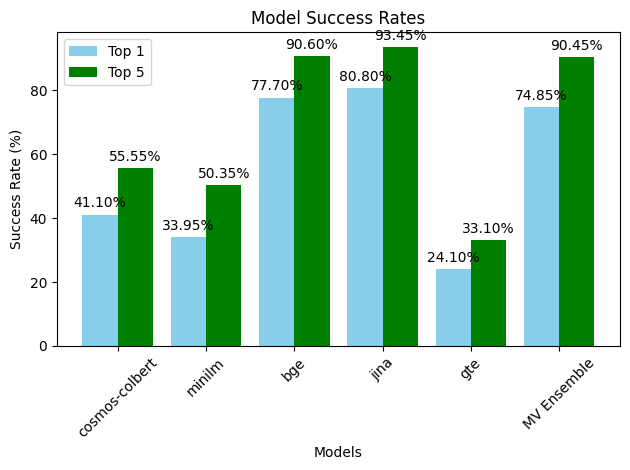

In [30]:
x = np.arange(len(model_names_voting_ensemble))
width = 0.4

plt.figure(figsize=(12, 7))
fig, ax = plt.subplots()
bar1 = ax.bar(x - width/2, top1_scores_voting_ensemble, width, label='Top 1', color='skyblue')
bar2 = ax.bar(x + width/2, top5_scores_voting_ensemble, width, label='Top 5', color="green")

# Add text labels on bars
for bar in bar1:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')
for bar in bar2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

ax.set_xlabel("Models")
ax.set_ylabel("Success Rate (%)")
ax.set_title("Model Success Rates")
ax.set_xticks(x)
ax.set_xticklabels(model_names_voting_ensemble, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

## ENSEMBLE-2: BORDA COUNT

- For Top1: Each model's Top1 result is scored based on its ranking (e.g., 1st place gets 5 points, 2nd place gets 4 points, etc.). The sentence with the highest total score across all models is selected as the ensemble Top1.
- For Top5: Each model's Top5 results are scored using Borda Count ranking points. The scores are summed across all models, and the 5 sentences with the highest total scores are selected as the ensemble Top5.

In [31]:
def borda_count_ensemble(models, df, output_dir, top_k=5):
    top1_votes = []
    top5_votes = []

    for model_name in models: # Collect top1 and top5 results for all models
        instruction_embeddings = np.load(os.path.join(output_dir, f"{model_name}_instruction_embeddings.npy"))
        output_embeddings = np.load(os.path.join(output_dir, f"{model_name}_output_embeddings.npy"))
        top_matches, _ = find_top_matches(instruction_embeddings, output_embeddings, top_k)

        top1_votes.append([df.iloc[top_matches[i][0]]['output'] for i in range(len(df))])
        top5_votes.append([[df.iloc[idx]['output'] for idx in top_matches[i]] for i in range(len(df))])

    ensemble_top1 = []
    ensemble_top5 = []

    for i in range(len(df)):
        top1_candidates = Counter([votes[i] for votes in top1_votes]) # Top1 Borda Count
        ensemble_top1.append(max(top1_candidates, key=top1_candidates.get))
        
        all_top5_candidates = defaultdict(int) # Top5 Borda Count
        for model_top5 in top5_votes:
            for rank, output in enumerate(model_top5[i], 1):
                all_top5_candidates[output] += top_k - rank + 1  # Borda scoring

        sorted_top5_candidates = sorted(all_top5_candidates.items(), key=lambda x: x[1], reverse=True)
        ensemble_top5.append([output for output, _ in sorted_top5_candidates[:top_k]])

    return ensemble_top1, ensemble_top5

In [32]:
ensemble_top1_borda, ensemble_top5_borda = borda_count_ensemble(models, df, output_dir)

In [33]:
ensemble_top1_rate_borda, ensemble_top5_rate_borda = evaluate_ensemble(df, ensemble_top1_borda, ensemble_top5_borda)

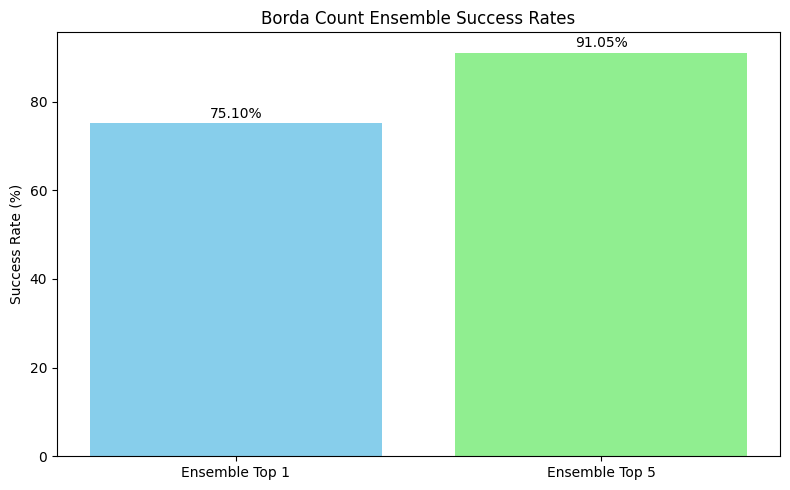

In [34]:
plt.figure(figsize=(8, 5))
plt.bar(["Ensemble Top 1", "Ensemble Top 5"], [ensemble_top1_rate_borda, ensemble_top5_rate_borda], color=['skyblue', 'lightgreen'])
plt.ylabel("Success Rate (%)")
plt.title("Borda Count Ensemble Success Rates")
for i, rate in enumerate([ensemble_top1_rate_borda, ensemble_top5_rate_borda]):
    plt.text(i, rate + 0.5, f"{rate:.2f}%", ha='center', va='bottom')
plt.tight_layout()
plt.show()


In [35]:
model_names_borda_ensemble = list(results.keys())
top1_scores_borda_ensemble = [results[model]['top1'] for model in model_names]
top5_scores_borda_ensemble = [results[model]['top5'] for model in model_names]

model_names_borda_ensemble.append("BC Ensemble")
top1_scores_borda_ensemble.append(ensemble_top1_rate_borda)
top5_scores_borda_ensemble.append(ensemble_top5_rate_borda)


<Figure size 1200x700 with 0 Axes>

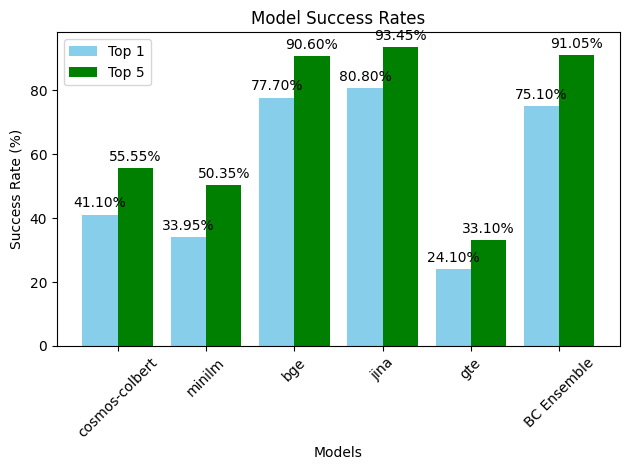

In [36]:
x = np.arange(len(model_names_borda_ensemble))
width = 0.4

plt.figure(figsize=(12, 7))
fig, ax = plt.subplots()
bar1 = ax.bar(x - width/2, top1_scores_borda_ensemble, width, label='Top 1', color='skyblue')
bar2 = ax.bar(x + width/2, top5_scores_borda_ensemble, width, label='Top 5', color="green")

for bar in bar1:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')
for bar in bar2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

ax.set_xlabel("Models")
ax.set_ylabel("Success Rate (%)")
ax.set_title("Model Success Rates")
ax.set_xticks(x)
ax.set_xticklabels(model_names_borda_ensemble, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

## ENSEMBLE-3: MEAN

- For Top1: Averages the Top1 scores of each model and selects the sentence with the highest average score.
- For Top5: Combines the sentences in the Top5 results of the models and averages the scores for the same sentences. The 5 sentences with the highest average score are selected.

In [37]:
def mean_ensemble(models, df, output_dir, top_k=5):
    top1_scores = []
    top5_scores = []

    for model_name in models: # Collect top1 and top5 results with scores for all models
        instruction_embeddings = np.load(os.path.join(output_dir, f"{model_name}_instruction_embeddings.npy"))
        output_embeddings = np.load(os.path.join(output_dir, f"{model_name}_output_embeddings.npy"))
        top_matches, similarities_list = find_top_matches(instruction_embeddings, output_embeddings, top_k)
        top1_scores.append([(df.iloc[indices[0]]['output'], similarities[0]) for indices, similarities in zip(top_matches, similarities_list)])
        top5_scores.append([[(df.iloc[idx]['output'], similarities[j]) for j, idx in enumerate(indices)] for indices, similarities in zip(top_matches, similarities_list)])

    ensemble_top1 = [] # Determine ensemble Top1
    for i in range(len(df)):
        all_top1 = defaultdict(list)
        for model_top1 in top1_scores:
            output, score = model_top1[i]
            all_top1[output].append(score)
        mean_scores = {output: np.mean(scores) for output, scores in all_top1.items()}
        selected = max(mean_scores, key=mean_scores.get)
        ensemble_top1.append(selected)
    
    ensemble_top5 = [] # Determine ensemble Top5
    for i in range(len(df)):
        all_top5 = defaultdict(list)
        for model_top5 in top5_scores:
            for output, score in model_top5[i]:
                all_top5[output].append(score)
        mean_scores = {output: np.mean(scores) for output, scores in all_top5.items()}
        sorted_top5 = sorted(mean_scores.items(), key=lambda x: x[1], reverse=True)
        top5_candidates = [output for output, _ in sorted_top5[:top_k]]
        ensemble_top5.append(top5_candidates)

    return ensemble_top1, ensemble_top5

In [38]:
ensemble_top1_mean, ensemble_top5_mean = mean_ensemble(models, df, output_dir)

In [39]:
ensemble_top1_rate_mean, ensemble_top5_rate_mean = evaluate_ensemble(df, ensemble_top1_mean, ensemble_top5_mean)

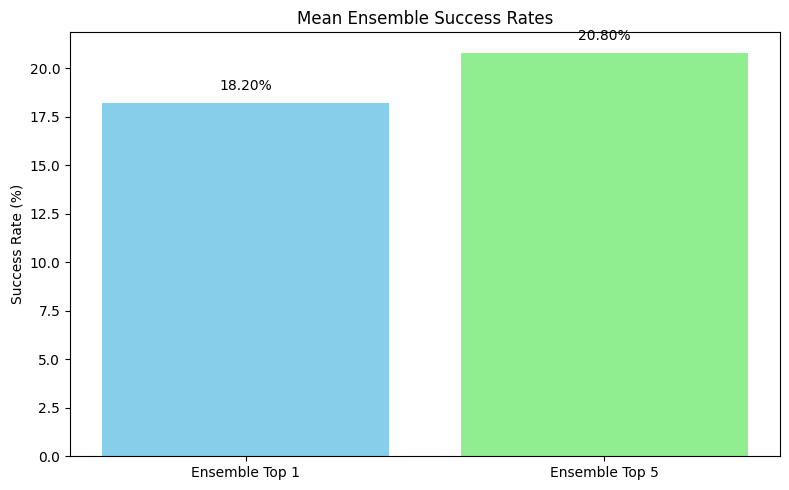

In [40]:
plt.figure(figsize=(8, 5))
plt.bar(["Ensemble Top 1", "Ensemble Top 5"], [ensemble_top1_rate_mean, ensemble_top5_rate_mean], color=['skyblue', 'lightgreen'])
plt.ylabel("Success Rate (%)")
plt.title("Mean Ensemble Success Rates")
for i, rate in enumerate([ensemble_top1_rate_mean, ensemble_top5_rate_mean]):
    plt.text(i, rate + 0.5, f"{rate:.2f}%", ha='center', va='bottom')
plt.tight_layout()
plt.show()


In [41]:
model_names_mean_ensemble = list(results.keys())
top1_scores_mean_ensemble = [results[model]['top1'] for model in model_names]
top5_scores_mean_ensemble = [results[model]['top5'] for model in model_names]

model_names_mean_ensemble.append("M Ensemble")
top1_scores_mean_ensemble.append(ensemble_top1_rate_mean)
top5_scores_mean_ensemble.append(ensemble_top5_rate_mean)


<Figure size 1200x700 with 0 Axes>

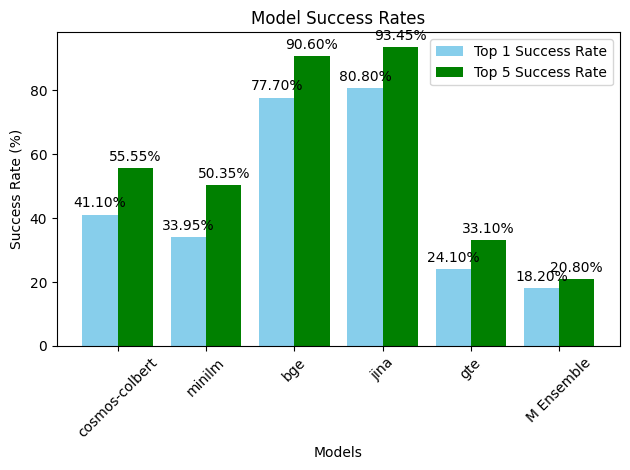

In [42]:
x = np.arange(len(model_names_mean_ensemble))
width = 0.4

plt.figure(figsize=(12, 7))
fig, ax = plt.subplots()
bar1 = ax.bar(x - width/2, top1_scores_mean_ensemble, width, label='Top 1 Success Rate', color= "skyblue")
bar2 = ax.bar(x + width/2, top5_scores_mean_ensemble, width, label='Top 5 Success Rate', color="green")

# Add text labels on bars
for bar in bar1:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')
for bar in bar2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

ax.set_xlabel("Models")
ax.set_ylabel("Success Rate (%)")
ax.set_title("Model Success Rates")
ax.set_xticks(x)
ax.set_xticklabels(model_names_mean_ensemble, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

<Figure size 1200x700 with 0 Axes>

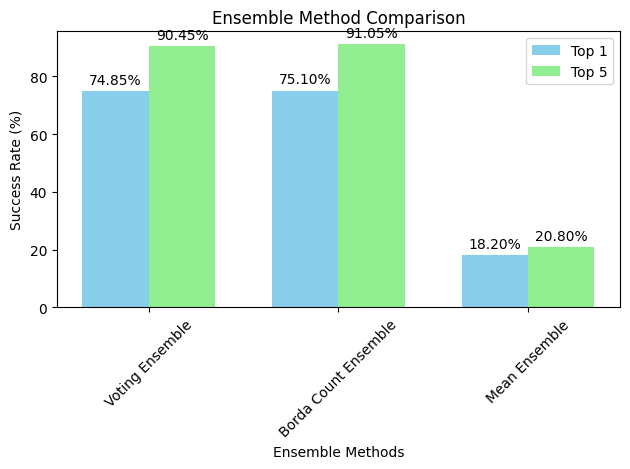

In [46]:
ensemble_methods = ["Voting Ensemble", "Borda Count Ensemble", "Mean Ensemble"]
ensemble_top1_rates = [ensemble_top1_rate, ensemble_top1_rate_borda, ensemble_top1_rate_mean]
ensemble_top5_rates = [ensemble_top5_rate, ensemble_top5_rate_borda, ensemble_top5_rate_mean]

x = np.arange(len(ensemble_methods))
width = 0.35

plt.figure(figsize=(12, 7))
fig, ax = plt.subplots()
bar1 = ax.bar(x - width/2, ensemble_top1_rates, width, label='Top 1', color='skyblue')
bar2 = ax.bar(x + width/2, ensemble_top5_rates, width, label='Top 5', color='lightgreen')

for bar in bar1:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')
for bar in bar2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

ax.set_xlabel("Ensemble Methods")
ax.set_ylabel("Success Rate (%)")
ax.set_title("Ensemble Method Comparison")
ax.set_xticks(x)
ax.set_xticklabels(ensemble_methods, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

## EXAMPLE

In [44]:
def get_results_for_first_instruction(models, df, output_dir, top_k=5):
    first_instruction = df.iloc[0]['instruction']
    original_output = df.iloc[0]['output']

    print(f"\n=== First Instruction ===")
    print(f"Instruction: {first_instruction}")
    print(f"Original Answer: {original_output}\n")

    for model_name in models:
        instruction_embeddings = np.load(os.path.join(output_dir, f"{model_name}_instruction_embeddings.npy"))
        output_embeddings = np.load(os.path.join(output_dir, f"{model_name}_output_embeddings.npy"))
        top_matches, similarities_list = find_top_matches(instruction_embeddings, output_embeddings, top_k)

        top1_output = df.iloc[top_matches[0][0]]['output']
        top5_outputs = [df.iloc[idx]['output'] for idx in top_matches[0]]

        print(f"Model: {model_name}")
        print(f"Top 1 Answer: {top1_output} (Similarity: {similarities_list[0][0]:.4f})")
        print("Top 5 Answers:")
        for rank, (output, similarity) in enumerate(zip(top5_outputs, similarities_list[0]), 1):
            print(f"  {rank}. {output} (Similarity: {similarity:.4f})")
        print()

    ensemble_top1_voting, ensemble_top5_voting = voting_ensemble(models, df, output_dir, top_k)
    ensemble_top1_max, ensemble_top5_max = borda_count_ensemble(models, df, output_dir, top_k)
    ensemble_top1_mean, ensemble_top5_mean = mean_ensemble(models, df, output_dir, top_k)

    print("Voting Ensemble Results:")
    print(f"Top 1 Answer: {ensemble_top1_voting[0]}")
    print("Top 5 Answers:")
    for rank, answer in enumerate(ensemble_top5_voting[0], 1):
        print(f"  {rank}. {answer}")
    print()

    print("Borda Count Ensemble Results:")
    print(f"Top 1 Answer: {ensemble_top1_max[0]}")
    print("Top 5 Answers:")
    for rank, answer in enumerate(ensemble_top5_max[0], 1):
        print(f"  {rank}. {answer}")
    print()

    print("Mean Ensemble Results:")
    print(f"Top 1 Answer: {ensemble_top1_mean[0]}")
    print("Top 5 Answers:")
    for rank, answer in enumerate(ensemble_top5_mean[0], 1):
        print(f"  {rank}. {answer}")


get_results_for_first_instruction(models, df, output_dir)



=== First Instruction ===
Instruction: Ders çalışma motivasyonu nasıl sağlanır?
Original Answer: Ders çalışma motivasyonunu arttırmak için, öncelikle ulaşılabilir ve ölçülebilir hedefler belirlemek önemlidir. Bu hedefleri belirlerken, çalışma zamanınızı planlayarak ve düzenli bir çalışma rutini oluşturarak başlayabilirsiniz. Ders çalışma sürecinde düzenli aralıklarla kısa molalar vermek, motivasyonunuzu korumanıza yardımcı olabilir. Ayrıca, ilginizi çeken konuları seçmek ve başarılarınızı kutlamak da motivasyonu artırabilir.

Model: cosmos-colbert
Top 1 Answer: Ders çalışma motivasyonunu arttırmak için, öncelikle ulaşılabilir ve ölçülebilir hedefler belirlemek önemlidir. Bu hedefleri belirlerken, çalışma zamanınızı planlayarak ve düzenli bir çalışma rutini oluşturarak başlayabilirsiniz. Ders çalışma sürecinde düzenli aralıklarla kısa molalar vermek, motivasyonunuzu korumanıza yardımcı olabilir. Ayrıca, ilginizi çeken konuları seçmek ve başarılarınızı kutlamak da motivasyonu artırabili